In [1]:
import torch
import copy
import torch.nn as nn
import networkx as nx
import scipy as sp
import numpy as np
from env.world import NetworkWorld
from model.random_agent import RandomAgent

import xarray
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt
%matplotlib inline

#### REMERGE replication

In [314]:
class REMERGE:
    def __init__(self):
        self.i2h = np.array([[1.,0.,0.,0.,0.],
                             [1.,1.,0.,0.,0.],
                             [0.,1.,1.,0.,0.],
                             [0.,0.,1.,1.,0.],
                             [0.,0.,0.,1.,1.],
                             [0.,0.,0.,0.,1.]])
        self.h2i = np.array([[1.,1.,0.,0.,0.,0.],
                             [0.,1.,1.,0.,0.,0.],
                             [0.,0.,1.,1.,0.,0.],
                             [0.,0.,0.,1.,1.,0.],
                             [0.,0.,0.,0.,1.,1.]])
        self.h2r = np.array([[1.,-1.,0.,0.,0.,0.],
                             [0.,1.,-1.,0.,0.,0.],
                             [0.,0.,1.,-1.,0.,0.],
                             [0.,0.,0.,1.,-1.,0.],
                             [0.,0.,0.,0.,1.,-1.]])
        
        self.netin_buffer = {'i':np.zeros((1,6)),
                             'h':np.zeros((1,5))}
        
        self.i_tau = 0.25
        self.h_tau = 0.25
        self.h_C = 1.
        
    def i_activation(self, netin):
        # logistic
        return np.array([1/(1+np.exp(-x/self.i_tau)) for x in netin])
    
    def h_activation(self, netin):
        # hedge softmax
        denom = self.h_C**(1/self.h_tau) + np.sum([np.exp(x/self.h_tau) for x in netin])
        return np.array([np.exp(x/self.h_tau)/denom for x in netin])
    
    def r_activation(self, netin):
        # logistic
        return np.array([1/(1+np.exp(-x/self.i_tau)) for x in netin])
    
    def forward(self, X):
        inetin = 0.2*(np.dot(self.h_activation(self.netin_buffer['h']),self.h2i) + 0.5*X) + 0.8*self.netin_buffer['i']
        hnetin = 0.2*(np.dot(self.i_activation(inetin),self.i2h)) + 0.8*self.netin_buffer['h']
        
        # update netin buffer        
        self.netin_buffer['i'] = inetin
        self.netin_buffer['h'] = hnetin
        
        # compute activation
        iact = self.i_activation(inetin)
        hact = self.h_activation(hnetin)
        ract = self.r_activation(np.dot(hact,self.h2r))
        
        return iact, hact, ract

In [336]:
trial = np.array([0.,1.,0.,1.,0.,0.])
trial = np.expand_dims(trial, 0)
trace = {'iact':[], 'hact':[], 'ract':[]}
m = REMERGE()
m.forward(trial)

(array([[0.53328404, 0.66075637, 0.56627439, 0.66075637, 0.56627439,
         0.53328404]]),
 array([[0.18545464, 0.19041437, 0.19041437, 0.19041437, 0.17195361]]),
 array([[0.6773934 , 0.50495957, 0.5       , 0.5       , 0.48154762,
         0.33451943]]))

In [355]:
trial = np.array([0.,1.,0.,1.,0.,0.])
trial = np.expand_dims(trial, 0)
trace = {'iact':[], 'hact':[], 'ract':[]}
m = REMERGE()
T = 100
for t in range(T):
    iact, hact, ract = m.forward(trial)
    trace['iact'].append(iact[0])
    trace['hact'].append(hact[0])
    trace['ract'].append(ract[0])
trace['iact'] = np.array(trace['iact'])
trace['hact'] = np.array(trace['hact'])
trace['ract'] = np.array(trace['ract'])

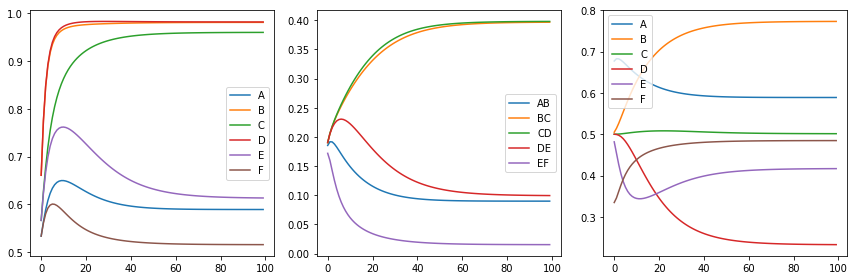

In [356]:
fig, axes = plt.subplots(1, 3, figsize=[12,4])

feature_labels = ['A','B','C','D','E','F']
conj_labels = ['AB','BC','CD','DE','EF']

# feature activation
for i,l in enumerate(feature_labels):
    axes[0].plot(range(T), trace['iact'][:, i], label=l)

# conjunction activation
for i,l in enumerate(conj_labels):
    axes[1].plot(range(T), trace['hact'][:, i], label=l)

# response activation
for i,l in enumerate(feature_labels):
    axes[2].plot(range(T), trace['ract'][:, i], label=l)
    
axes[0].legend()
axes[1].legend()
axes[2].legend()

fig.tight_layout()

#### REMERGE-style (s,a,ns) transition 3-way association memory

In [2]:
W1 = {}
W1['edges'] = {0:[14,1,2,3],
               1:[0,2,3,4],
               2:[1,3,4,0],
               3:[2,4,0,1],
               4:[3,5,1,2],
               5:[4,6,7,8],
               6:[5,7,8,9],
               7:[6,8,9,5],
               8:[7,9,5,6],
               9:[8,10,6,7],
               10:[9,11,12,13],
               11:[10,12,13,14],
               12:[11,13,14,10],
               13:[12,14,10,11],
               14:[13,0,11,12]}
W1['nodes'] = np.array(list(W1['edges'].keys()))

W2 = {}
W2['edges'] = {0:[14,3], 1:[0,4], 2:[1,0],
         3:[2,1], 4:[3,2], 5:[4,8],
         6:[5,9], 7:[6,5], 8:[7,6],
         9:[8,7], 10:[9,13], 11:[10,14],
         12:[11,10], 13:[12,11], 14:[13,12]}
W2['nodes'] = np.array(list(W2['edges'].keys()))

w1 = NetworkWorld(W1['nodes'], W1['edges'], action_dim=4)
w2 = NetworkWorld(W2['nodes'], W2['edges'], action_dim=4)
ra = RandomAgent(action_dim=4)

In [3]:
def collect_data(N, world, agent):
    
    data = []
    for i in range(N):
        s = world.reset()
        a = agent.step(s)
        ns = world.step(a)
        data.append([s, a, ns])
    
    return np.array(data)

In [213]:
class HardWiredMemory:

    def __init__(self, i_tau=0.25, h_tau=0.25, h_C=1., lmda=0.2, ext=0.5):
        
        weight_scale = 0.2
        
        all_transitions = []
        for n in W1['edges'].keys():
            for a in range(4):
                all_transitions.append((n,a,W1['edges'][n][a]))
                
        self.s2h = []
        for s in range(15):
            self.s2h.append([float(transition[0]==s) for transition in all_transitions])
        self.s2h = np.array(self.s2h)
        self.s2h[self.s2h==0] = -0.2
        self.s2h = self.s2h * weight_scale
        
        self.a2h = []
        for a in range(4):
            self.a2h.append([float(transition[1]==a) for transition in all_transitions])
        self.a2h = np.array(self.a2h)
        self.a2h[self.a2h==0] = -0.2
        self.a2h = self.a2h * weight_scale
        
        self.ns2h = []
        for ns in range(15):
            self.ns2h.append([float(transition[2]==ns) for transition in all_transitions])
        self.ns2h = np.array(self.ns2h)
        self.ns2h[self.ns2h==0] = -0.2
        self.ns2h = self.ns2h * weight_scale
        
        self.h2s = []
        for transition in all_transitions:
            self.h2s.append([float(s==transition[0]) for s in range(15)])
        self.h2s = np.array(self.h2s)
        self.h2s[self.h2s==0] = -0.2
        self.h2s = self.h2s * weight_scale
        
        self.h2a = []
        for transition in all_transitions:
            self.h2a.append([float(a==transition[1]) for a in range(4)])
        self.h2a = np.array(self.h2a)
        self.h2a[self.h2a==0] = -0.2
        self.h2a = self.h2a * weight_scale
        
        self.h2ns = []
        for transition in all_transitions:
            self.h2ns.append([float(ns==transition[2]) for ns in range(15)])
        self.h2ns = np.array(self.h2ns)
        self.h2ns[self.h2ns==0] = -0.2
        self.h2ns = self.h2ns * weight_scale
        
        self.netin_buffer = {'s':np.zeros((1,15)),
                             'a':np.zeros((1,4)),
                             'ns':np.zeros((1,15)),
                             'h':np.zeros((1,60))}
        
        self.i_tau = i_tau
        self.h_tau = h_tau
        self.h_C = h_C
        self.lmda = lmda
        self.ext = ext
    
    def i_activation(self, netin):
        # logistic
        return np.array([1/(1+np.exp(-x/self.i_tau)) for x in netin])
        # denom = np.sum([np.exp(x/self.i_tau) for x in netin])
        # return np.array([np.exp(x/self.i_tau)/denom for x in netin])
    
    def h_activation(self, netin):
        # hedge softmax
        denom = self.h_C**(1/self.h_tau) + np.sum([np.exp(x/self.h_tau) for x in netin])
        return np.array([np.exp(x/self.h_tau)/denom for x in netin])
    
    def forward(self, s_in=np.zeros((1,15)), a_in=np.zeros((1,4)), ns_in=np.zeros((1,15))):
        
        snetin = self.lmda*(np.dot(self.h_activation(self.netin_buffer['h']),self.h2s) + self.ext*s_in) + (1-self.lmda)*self.netin_buffer['s']
        anetin = self.lmda*(np.dot(self.h_activation(self.netin_buffer['h']),self.h2a) + self.ext*a_in) + (1-self.lmda)*self.netin_buffer['a']
        nsnetin = self.lmda*(np.dot(self.h_activation(self.netin_buffer['h']),self.h2ns) + self.ext*ns_in) + (1-self.lmda)*self.netin_buffer['ns']
        hnetin = np.dot(self.i_activation(snetin),self.s2h) + np.dot(self.i_activation(anetin),self.a2h) + np.dot(self.i_activation(nsnetin),self.ns2h)
        hnetin = self.lmda*(hnetin) + (1-self.lmda)*self.netin_buffer['h']
        
        # update netin buffer
        self.netin_buffer['s'] = snetin
        self.netin_buffer['a'] = anetin
        self.netin_buffer['ns'] = nsnetin
        self.netin_buffer['h'] = hnetin
        
        # compute activation
        sact = self.i_activation(snetin)
        aact = self.i_activation(anetin)
        nsact = self.i_activation(nsnetin)
        hact = self.h_activation(hnetin)
        
        return sact, aact, nsact, hact

class HardWiredMemory2:

    def __init__(self, i_tau=0.25, h_tau=0.25, h_C=1., lmda=0.2, ext=0.5):
        
        all_transitions = []
        for n in W1['edges'].keys():
            for a in range(4):
                all_transitions.append((n,a,W1['edges'][n][a]))
                
        self.s2h = []
        for s in range(15):
            self.s2h.append([float(transition[0]==s) for transition in all_transitions])
        self.s2h = np.array(self.s2h)
        self.s2h[self.s2h==0] = -0.2
        
        self.ns2h = []
        for ns in range(15):
            self.ns2h.append([float(transition[2]==ns) for transition in all_transitions])
        self.ns2h = np.array(self.ns2h)
        self.ns2h[self.ns2h==0] = -0.2
        
        self.h2s = []
        for transition in all_transitions:
            self.h2s.append([float(s==transition[0]) for s in range(15)])
        self.h2s = np.array(self.h2s)
        self.h2s[self.h2s==0] = -0.2
        
        self.h2ns = []
        for transition in all_transitions:
            self.h2ns.append([float(ns==transition[2]) for ns in range(15)])
        self.h2ns = np.array(self.h2ns)
        self.h2ns[self.h2ns==0] = -0.2
        
        self.netin_buffer = {'s':np.zeros((1,15)),
                             'ns':np.zeros((1,15)),
                             'h':np.zeros((1,60))}
        
        self.i_tau = i_tau
        self.h_tau = h_tau
        self.h_C = h_C
        self.lmda = lmda
        self.ext = ext
    
    def i_activation(self, netin):
        # logistic
        # return np.array([1/(1+np.exp(-x/self.i_tau)) for x in netin])
        denom = np.sum([np.exp(x/self.i_tau) for x in netin])
        return np.array([np.exp(x/self.i_tau)/denom for x in netin])
    
    def h_activation(self, netin):
        # hedge softmax
        denom = self.h_C**(1/self.h_tau) + np.sum([np.exp(x/self.h_tau) for x in netin])
        return np.array([np.exp(x/self.h_tau)/denom for x in netin])
    
    def forward(self, s_in=np.zeros((1,15)), ns_in=np.zeros((1,15))):
        
        snetin = self.lmda*(np.dot(self.h_activation(self.netin_buffer['h']),self.h2s) + self.ext*s_in) + (1-self.lmda)*self.netin_buffer['s']
        nsnetin = self.lmda*(np.dot(self.h_activation(self.netin_buffer['h']),self.h2ns) + self.ext*ns_in) + (1-self.lmda)*self.netin_buffer['ns']
        hnetin = np.dot(self.i_activation(snetin),self.s2h) + np.dot(self.i_activation(nsnetin),self.ns2h)
        hnetin = self.lmda*(hnetin) + (1-self.lmda)*self.netin_buffer['h']
        
        # update netin buffer
        self.netin_buffer['s'] = snetin
        self.netin_buffer['ns'] = nsnetin
        self.netin_buffer['h'] = hnetin
        
        # compute activation
        sact = self.i_activation(snetin)
        nsact = self.i_activation(nsnetin)
        hact = self.h_activation(hnetin)
        
        return sact, nsact, hact

In [83]:
# sample a transition to test
# transition = collect_data(1, w1, ra)
# print(transition[0])
# s, a, ns = transition[0]

# set non-adjacent states
s = 2
ns = 12

# create one-hot representation
s_in = np.zeros((1,15))
a_in = np.zeros((1,4))
ns_in = np.zeros((1,15))
s_in[0][s] = 1.
a_in[0][a] = 1.
ns_in[0][ns] = 1.

# run recurrence computation
m = HardWiredMemory(i_tau=0.1, h_tau=0.1, h_C=0., lmda=0.2, ext=0.5)
trace = {'sact':[], 'aact':[], 'nsact':[], 'hact':[]}
T = 200
for t in range(T):
    if (t<10):
        sact, aact, nsact, hact = m.forward(s_in=s_in, ns_in=ns_in)
    else:
        sact, aact, nsact, hact = m.forward()
    trace['sact'].append(sact[0])
    trace['aact'].append(aact[0])
    trace['nsact'].append(nsact[0])
trace['sact'] = np.array(trace['sact'])
trace['aact'] = np.array(trace['aact'])
trace['nsact'] = np.array(trace['nsact'])

NameError: name 'a' is not defined

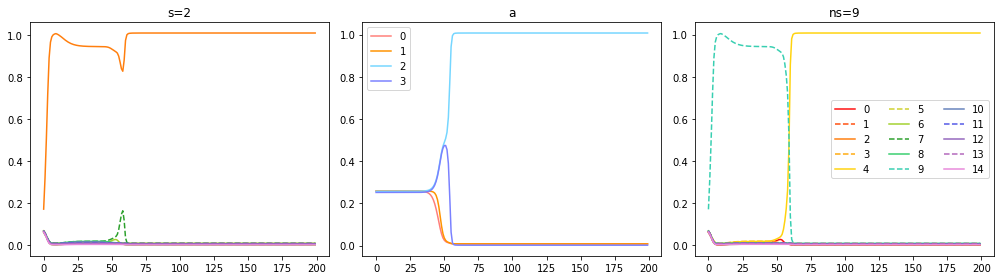

In [1412]:
fig, axes = plt.subplots(1, 3, figsize=[14,4])

colors = ['#ff0e0e','#ff4e0e','C1','#ffab0e','#ffd30e'] + ['#ced12e','#a3d12e','C2','#38cf6f','#38cfb1'] + ['#6782bc','#5358e6','C4','#b267bc','#e889db']
action_colors = ['#FF7E79','#FF9300','#75D6FF','#7A81FF']
ls = ['-','--']*7+['-']

for i in range(15):
    axes[0].plot(range(T), trace['sact'][:, i]+np.random.uniform()*0.01, label=i,
                 color = colors[i], ls=ls[i])

for i in range(4):
    axes[1].plot(range(T), trace['aact'][:, i]+np.random.uniform()*0.01, label=i,
                 color = action_colors[i])

for i in range(15):
    axes[2].plot(range(T), trace['nsact'][:, i]+np.random.uniform()*0.01, label=i,
                 color = colors[i], ls=ls[i])

axes[0].set_title('s=%d'%s)
axes[1].set_title('a')
axes[2].set_title('ns=%d'%ns)
# axes[0].legend(ncol=3)
axes[1].legend()
axes[2].legend(ncol=3)

fig.tight_layout()

# fig.savefig('plot_temp/20.pdf')

In [190]:
# set non-adjacent states
s = 2
ns = 14

# create one-hot representation
s_in = np.zeros((1,15))
ns_in = np.zeros((1,15))
s_in[0][s] = 1.
ns_in[0][ns] = 1.

# run recurrence computation
m = HardWiredMemory2(i_tau=0.1, h_tau=0.1, h_C=0., lmda=0.2, ext=0.1)
trace = {'sact':[], 'nsact':[], 'hact':[]}
T = 200
for t in range(T):
    if (t<T):
        sact, nsact, hact = m.forward(s_in=s_in, ns_in=ns_in)
    else:
        sact, nsact, hact = m.forward()
    trace['sact'].append(sact[0])
    trace['nsact'].append(nsact[0])
trace['sact'] = np.array(trace['sact'])
trace['nsact'] = np.array(trace['nsact'])

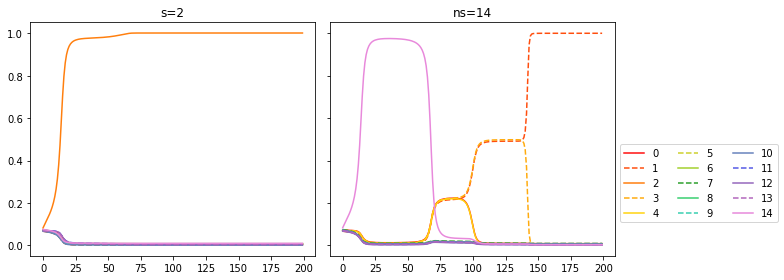

In [191]:
fig, axes = plt.subplots(1, 2, sharey=True, sharex=True, figsize=[11,4])

colors = ['#ff0e0e','#ff4e0e','C1','#ffab0e','#ffd30e'] + ['#ced12e','#a3d12e','C2','#38cf6f','#38cfb1'] + ['#6782bc','#5358e6','C4','#b267bc','#e889db']
ls = ['-','--']*7+['-']

for i in range(15):
    axes[0].plot(range(T), trace['sact'][:, i]+np.random.uniform()*0.01, label=i,
                 color = colors[i], ls=ls[i])

for i in range(15):
    axes[1].plot(range(T), trace['nsact'][:, i]+np.random.uniform()*0.01, label=i,
                 color = colors[i],ls=ls[i])

axes[0].set_title('s=%d'%s)
axes[1].set_title('ns=%d'%ns)
axes[1].legend(ncol=3, bbox_to_anchor=(1, 0.5))

fig.tight_layout()

# fig.savefig('plot_temp/sns_2.pdf')

#### Two network settling together

In [214]:
# set non-adjacent states
s = 2
ns = 12

# create one-hot representation
s_in = np.zeros((1,15))
ns_in = np.zeros((1,15))
s_in[0][s] = 1.
ns_in[0][ns] = 1.

# run recurrence computation
m1 = HardWiredMemory(i_tau=0.1, h_tau=0.04, h_C=0., lmda=0.2, ext=0.2)
m2 = HardWiredMemory(i_tau=0.1, h_tau=0.04, h_C=0., lmda=0.2, ext=0.2)
for t in range(1):
    m1sact, m1aact, m1nsact, m1hact = m1.forward(s_in=s_in)
    m2sact, m2aact, m2nsact, m2hact = m2.forward(ns_in=ns_in)

trace = {'m1sact':[], 'm1aact':[], 'm1nsact':[], 'm1hact':[],
         'm2sact':[], 'm2aact':[], 'm2nsact':[], 'm2hact':[]}
T = 200
for t in range(T):
#     if (t%50<5):
    m1sact, m1aact, m1nsact, m1hact = m1.forward(ns_in=m2sact)
    m2sact, m2aact, m2nsact, m2hact = m2.forward(s_in=m1nsact)
#     else:
#         m1sact, m1aact, m1nsact, m1hact = m1.forward(s_in=m1nsact)
#         # m2sact, m2aact, m2nsact, m2hact = m2.forward(ns_in=m2sact)
    trace['m1sact'].append(m1sact[0])
    trace['m1aact'].append(m1aact[0])
    trace['m1nsact'].append(m1nsact[0])
    trace['m2sact'].append(m2sact[0])
    trace['m2aact'].append(m2aact[0])
    trace['m2nsact'].append(m2nsact[0])
trace['m1sact'] = np.array(trace['m1sact'])
trace['m1aact'] = np.array(trace['m1aact'])
trace['m1nsact'] = np.array(trace['m1nsact'])
trace['m2sact'] = np.array(trace['m2sact'])
trace['m2aact'] = np.array(trace['m2aact'])
trace['m2nsact'] = np.array(trace['m2nsact'])

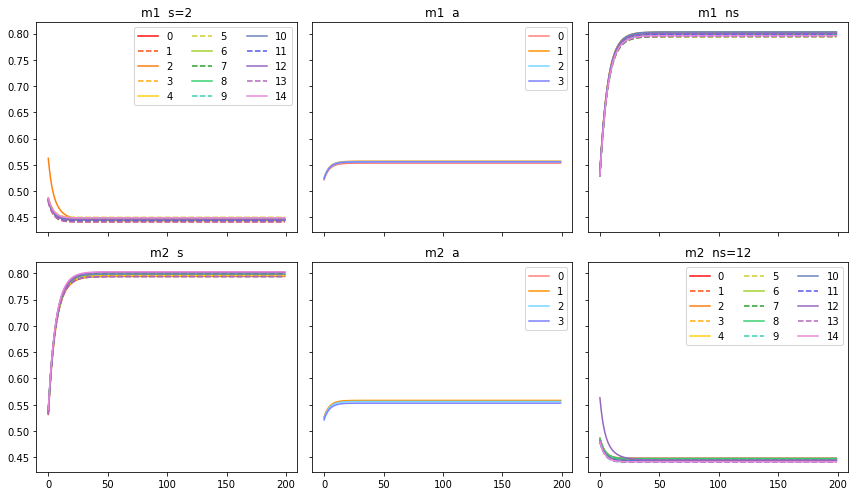

In [215]:
fig, axes = plt.subplots(2, 3, sharey=True, sharex=True, figsize=[12,7])

colors = ['#ff0e0e','#ff4e0e','C1','#ffab0e','#ffd30e'] + ['#ced12e','#a3d12e','C2','#38cf6f','#38cfb1'] + ['#6782bc','#5358e6','C4','#b267bc','#e889db']
action_colors = ['#FF7E79','#FF9300','#75D6FF','#7A81FF']
ls = ['-','--']*7+['-']

for i in range(15):
    axes[0,0].plot(range(T), trace['m1sact'][:, i]+np.random.uniform()*0.01, label=i,
                 color = colors[i], ls=ls[i])
    axes[1,0].plot(range(T), trace['m2sact'][:, i]+np.random.uniform()*0.01, label=i,
                 color = colors[i], ls=ls[i])

for i in range(4):
    axes[0,1].plot(range(T), trace['m1aact'][:, i]+np.random.uniform()*0.01, label=i,
                 color = action_colors[i])
    axes[1,1].plot(range(T), trace['m2aact'][:, i]+np.random.uniform()*0.01, label=i,
                 color = action_colors[i])

for i in range(15):
    axes[0,2].plot(range(T), trace['m1nsact'][:, i]+np.random.uniform()*0.01, label=i,
                 color = colors[i], ls=ls[i])
    axes[1,2].plot(range(T), trace['m2nsact'][:, i]+np.random.uniform()*0.01, label=i,
                 color = colors[i], ls=ls[i])

axes[0,0].set_title('m1  s=%d'%s)
axes[0,1].set_title('m1  a')
axes[0,2].set_title('m1  ns')
axes[1,0].set_title('m2  s')
axes[1,1].set_title('m2  a')
axes[1,2].set_title('m2  ns=%d'%ns)
axes[0,0].legend(ncol=3)
axes[0,1].legend()
axes[1,1].legend()
axes[1,2].legend(ncol=3)

fig.tight_layout()

# fig.savefig('plot_temp/2m_8.pdf')

#### successor/precessor representation

In [119]:
# true infinite successor representation
sucrep = np.zeros((15,15))
N=1000
T=1000
discount = [0.9**t for t in range(T)]
for s in range(15):
    probs = np.zeros((N, 15))
    for n in range(N):
        w1.current = s
        traj = np.zeros(T)
        for t in range(T):
            ns = w1.step(ra.step(w1.current))
            traj[t] = ns
        probs[n] = [np.sum(np.dot(discount, traj==s)) for s in range(15)]
    sucrep[s] = probs.mean(0)

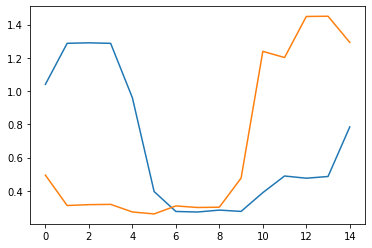

In [120]:
plt.figure()
plt.plot(sucrep[0])
plt.plot(sucrep[11])

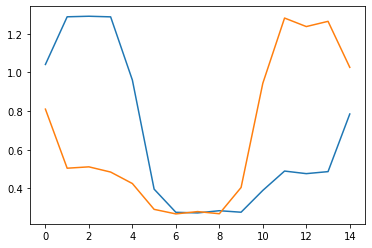

In [121]:
plt.figure()
plt.plot(sucrep[0])
plt.plot(sucrep[14])

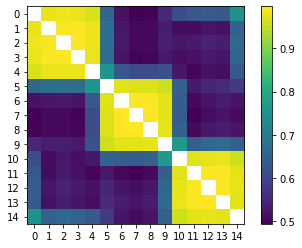

In [141]:
sucrepdistmat = np.array([cosine_similarity([x], sucrep)[0] for x in sucrep])
sucrepdistmat[np.isclose(sucrepdistmat, 1)] = np.nan
plt.imshow(sucrepdistmat)
ax = plt.gca()
ax.set_yticks(range(15))
ax.set_xticks(range(15))
plt.colorbar()

In [150]:
# true infinite successor representation
sucrep_w2 = np.zeros((15,15))
N=1000
T=1000
discount = [0.9**t for t in range(T)]
for s in range(15):
    probs = np.zeros((N, 15))
    for n in range(N):
        w2.current = s
        traj = np.zeros(T)
        for t in range(T):
            ns = w2.step(np.random.choice([0,1]))
            traj[t] = ns
        probs[n] = [np.sum(np.dot(discount, traj==s)) for s in range(15)]
    sucrep_w2[s] = probs.mean(0)

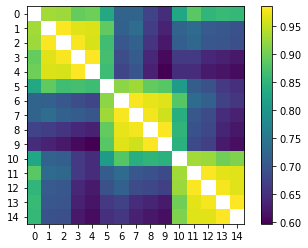

In [152]:
sucrepdistmat = np.array([cosine_similarity([x], sucrep_w2)[0] for x in sucrep_w2])
sucrepdistmat[np.isclose(sucrepdistmat, 1)] = np.nan
plt.imshow(sucrepdistmat)
ax = plt.gca()
ax.set_yticks(range(15))
ax.set_xticks(range(15))
plt.colorbar()

In [145]:
# successor representation
hidden_activation_matrix = []

for s in range(15):
    s_in = np.zeros((1,15))
    s_in[0][s] = 1.
    m = HardWiredMemory()
    T = 50
    for t in range(T):
        sact, aact, nsact, hact = m.forward(s_in=s_in)
    hidden_activation_matrix.append(hact.flatten())
hidden_activation_matrix = np.array(hidden_activation_matrix)

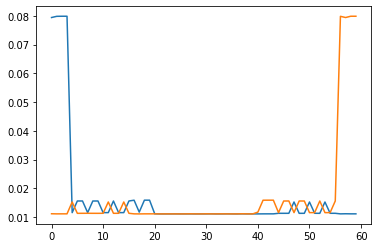

In [146]:
plt.figure()
plt.plot(hidden_activation_matrix[0])
plt.plot(hidden_activation_matrix[14])

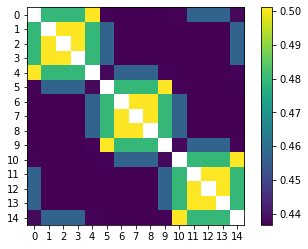

In [147]:
distmat = np.array([cosine_similarity([h], hidden_activation_matrix)[0] for h in hidden_activation_matrix])
distmat[np.isclose(distmat, 1)] = np.nan
plt.imshow(distmat)
ax = plt.gca()
ax.set_yticks(range(15))
ax.set_xticks(range(15))
plt.colorbar()

/home/liyuxuan/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


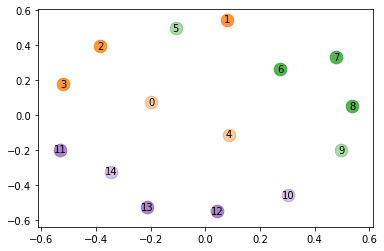

In [910]:
# distmat_copy = distmat.copy()
mds_coords = MDS(n_components=2).fit_transform(distmat_copy)
fig, ax = plt.subplots(figsize=[6,4])

for i in range(15):
    if i < 5:
        c = 'C1'
        a = 0.4 if i in [0,4] else 0.8 
    elif i < 10:
        c = 'C2'
        a = 0.4 if i in [5,9] else 0.8
    else:
        c = 'C4'
        a = 0.4 if i in [10,14] else 0.8
    ax.text(mds_coords[i,0], mds_coords[i,1], '%d'%i,
            ha='center', va='center')
    ax.scatter(mds_coords[i,0], mds_coords[i,1], 
               color=c, alpha=a, s=160)

In [885]:
# precessor representation

hidden_activation_matrix = []

for ns in range(15):
    ns_in = np.zeros((1,15))
    ns_in[0][ns] = 1.
    m = HardWiredMemory()
    T = 50
    for t in range(T):
        sact, aact, nsact, hact = m.forward(ns_in=ns_in)
    hidden_activation_matrix.append(hact.flatten())
hidden_activation_matrix = np.array(hidden_activation_matrix)

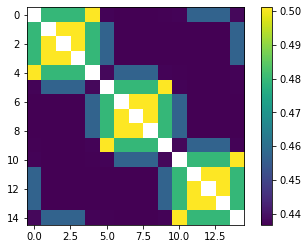

In [892]:
distmat = np.array([cosine_similarity([h], hidden_activation_matrix)[0] for h in hidden_activation_matrix])
distmat[np.isclose(distmat, 1)] = np.nan
plt.imshow(distmat)
plt.colorbar()

#### without action

#### Learn the 3-way association

In [105]:
class HubModel(nn.Module):

    def __init__(self, state_size, action_size, hidden_size):
        super(HubModel, self).__init__()
        
        self.s = nn.Sigmoid()
        self.ns = nn.Sigmoid()
        self.s2h = nn.Linear(state_size, hidden_size)
        self.ns2h = nn.Linear(state_size, hidden_size)
        self.h = nn.Sigmoid()
        self.h2s = nn.Linear(hidden_size, state_size)
        self.h2ns = nn.Linear(hidden_size, state_size)
        
        self.activ_buffer = {'s':torch.zeros((1,state_size)),
                             'ns':torch.zeros((1,state_size)),
                             'h':torch.zeros((1,hidden_size))}

    def forward(self, s_in=None, a_in=None, ns_in=None):
        
        # modality to hidden
        s_act = s_in if s_in is not None else self.activ_buffer['s']
        ns_act = ns_in if ns_in is not None else self.activ_buffer['ns']
        h_netin = self.s2h(s_act) + self.ns2h(ns_act)
        h_act = self.h(h_netin)
        
        # hidden to modality
        s_netin = self.h2s(self.activ_buffer['h']) # self.h2s(h_act)
        ns_netin = self.h2ns(self.activ_buffer['h']) # self.h2ns(h_act)
        s_act = self.s(s_netin)
        ns_act = self.ns(ns_netin)
        
        # update buffer
        self.activ_buffer['s'] = copy.deepcopy(s_act.data)
        self.activ_buffer['ns'] = copy.deepcopy(ns_act.data)
        self.activ_buffer['h'] = copy.deepcopy(h_act.data)
        
        return s_act, ns_act, h_act

In [112]:
def train(epoch_size, batch_size, verbose=True):

    m = HubModel(15, 4, 60)
    print(m.h2ns.weight[0])
    optimizer = torch.optim.SGD(m.parameters(), lr=0.02)

    for i in range(epoch_size):
        
        for b in range(batch_size):

            data = collect_data(1, w1, ra)
            s = torch.tensor(data[:, 0])
            a = torch.tensor(data[:, 1])
            ns = torch.tensor(data[:, 2])
            # one-hot
            s_in = torch.nn.functional.one_hot(s, 15).type('torch.FloatTensor')
            ns_in = torch.nn.functional.one_hot(ns, 15).type('torch.FloatTensor')

            # 1-3 mapping
            # choose randomly from (s, a, ns) as the input
            # mode = np.random.choice(['s','ns'])
            mode = 's'
            loss = []

            # cycle T times
            T = 2
            for t in range(T):
                if t==0:
                    m.forward(s_in=s_in)
                if t==1:
                    s_act, ns_act, h_act = m.forward()
                    print(s_act, s_in)
                    loss.append(nn.MSELoss()(s_act, s_in))
                    # loss.append(nn.MSELoss()(ns_act, ns_in))

    #             if t < 2: # t=0,1
    #                 # clamp input to corresponding modality
    #                 if mode == 's':
    #                     m.forward(s_in=s_in)
    #                 elif mode == 'ns':
    #                     m.forward(ns_in=ns_in)
    #             elif t < 4: # t=2,3
    #                 # let it roll
    #                 m.forward()
    #             else: # t=4,5
    #                 # compute loss
    #                 s_act, ns_act, h_act = m.forward()
    #                 # loss.append(nn.CrossEntropyLoss()(s_act, s))
    #                 # loss.append(nn.CrossEntropyLoss()(ns_act, ns))
    #                 loss.append(nn.MSELoss()(s_act, s_in))
    #                 loss.append(nn.MSELoss()(ns_act, ns_in))

        loss = torch.stack(loss).sum()
        if torch.isnan(loss):
            return m
        loss.backward(retain_graph=True)
        optimizer.step()

        if verbose and (i % (epoch_size/10.0)==0):
            print('epoch: %d  |  loss: %f' % (i, loss))

    return m

In [113]:
m = train(10, 1)

tensor([-0.1146, -0.1051,  0.0152,  0.0020,  0.0765,  0.0470,  0.0781,  0.0321,
         0.0060,  0.0812, -0.0838, -0.0044, -0.0377,  0.0137,  0.0121, -0.0954,
         0.0946,  0.0313, -0.0933, -0.0584,  0.1146, -0.0018,  0.1224, -0.1047,
         0.0169, -0.1033,  0.0571,  0.0986, -0.0277, -0.0388, -0.1066, -0.1196,
        -0.1150, -0.0841,  0.0827,  0.0469,  0.0595, -0.0068, -0.0430, -0.0445,
        -0.0263, -0.0634,  0.0734, -0.0229,  0.0115,  0.0583, -0.0518,  0.0333,
         0.1181,  0.0861,  0.1160, -0.0451,  0.0307, -0.1005,  0.0398, -0.0310,
         0.0071, -0.0883,  0.1111, -0.0896], grad_fn=<SelectBackward>)
tensor([[0.3945, 0.4738, 0.4978, 0.4902, 0.3889, 0.5010, 0.4657, 0.3467, 0.5381,
         0.5299, 0.4029, 0.4106, 0.5288, 0.6016, 0.5889]],
       grad_fn=<SigmoidBackward>) tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]])
epoch: 0  |  loss: 0.219603
tensor([[0.3976, 0.4898, 0.4800, 0.4987, 0.3607, 0.4972, 0.4632, 0.3641, 0.5471,
         0.5463

In [111]:
print(m.h2ns.weight[0])

tensor([-0.0732,  0.1057, -0.0665, -0.0272,  0.1169, -0.1275,  0.1221, -0.0276,
         0.0583, -0.0604, -0.0825,  0.0218,  0.1201,  0.0671,  0.1220,  0.0990,
         0.1039,  0.0013, -0.1263,  0.1156,  0.0462,  0.1163, -0.0613, -0.1063,
        -0.0421, -0.0610, -0.1178, -0.0478,  0.0591, -0.1097,  0.0152, -0.0637,
        -0.1106,  0.1125, -0.0739,  0.1139,  0.0337,  0.0662,  0.0533, -0.0796,
         0.0432,  0.0215, -0.0888,  0.0023,  0.0274, -0.0938, -0.0858, -0.1253,
         0.0064,  0.0764,  0.1172, -0.1217,  0.0674, -0.1259,  0.0399, -0.1284,
        -0.0338,  0.1128,  0.1024, -0.0104], grad_fn=<SelectBackward>)


In [95]:
# sample a transition to test
transition = collect_data(1, w1, ra)
print(transition[0])
s, a, ns = transition[0]

# set non-adjacent states
# s = 2
# ns = 9

# create one-hot representation
s = torch.tensor(s)
ns = torch.tensor(ns)
s_in = torch.nn.functional.one_hot(s, 15).type('torch.FloatTensor')
ns_in = torch.nn.functional.one_hot(ns, 15).type('torch.FloatTensor')

# run recurrence computation
trace = {'sact':[], 'nsact':[], 'hact':[]}
T = 6
for t in range(T):
    if (t<2):
        s_act, ns_act, h_act = m.forward(s_in=s_in)
    else:
        s_act, ns_act, h_act = m.forward()
    trace['sact'].append(sact[0])
    trace['nsact'].append(nsact[0])
trace['sact'] = np.array(trace['sact'])
trace['nsact'] = np.array(trace['nsact'])

[3 0 2]


No handles with labels found to put in legend.


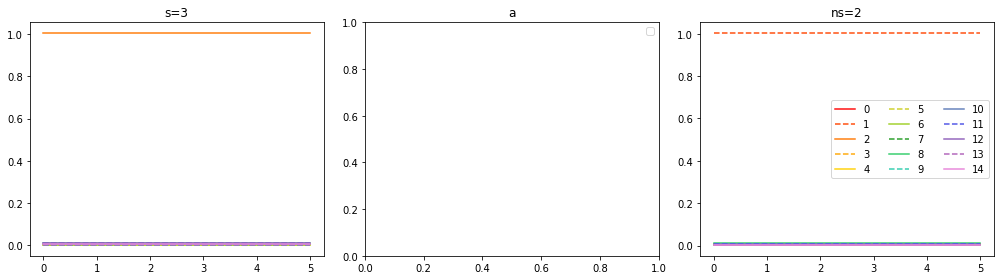

In [96]:
fig, axes = plt.subplots(1, 3, figsize=[14,4])

colors = ['#ff0e0e','#ff4e0e','C1','#ffab0e','#ffd30e'] + ['#ced12e','#a3d12e','C2','#38cf6f','#38cfb1'] + ['#6782bc','#5358e6','C4','#b267bc','#e889db']
action_colors = ['#FF7E79','#FF9300','#75D6FF','#7A81FF']
ls = ['-','--']*7+['-']

for i in range(15):
    axes[0].plot(range(T), trace['sact'][:, i]+np.random.uniform()*0.01, label=i,
                 color = colors[i], ls=ls[i])

# for i in range(4):
#     axes[1].plot(range(T), trace['aact'][:, i]+np.random.uniform()*0.01, label=i,
#                  color = action_colors[i])

for i in range(15):
    axes[2].plot(range(T), trace['nsact'][:, i]+np.random.uniform()*0.01, label=i,
                 color = colors[i], ls=ls[i])

axes[0].set_title('s=%d'%s)
axes[1].set_title('a')
axes[2].set_title('ns=%d'%ns)
# axes[0].legend(ncol=3)
axes[1].legend()
axes[2].legend(ncol=3)

fig.tight_layout()

# fig.savefig('plot_temp/20.pdf')